In [19]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [20]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils.LearningCutsUtils import loss_fn
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn

In [3]:
N=20000 # number of points
m=10 # dimensions

In [4]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

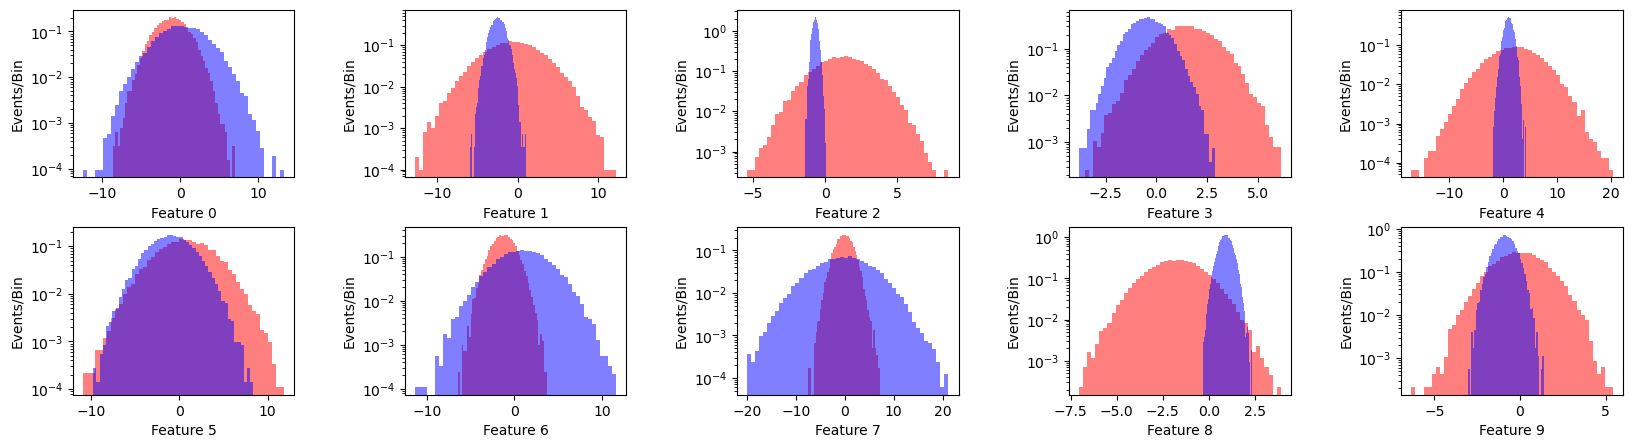

In [5]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [8]:
gt=1.
lt=-1.
cuts_gt_lt = []
if m==10:
    cuts_gt_lt = [lt, gt, gt, gt, lt,
                  gt, lt, lt, lt, gt]
elif m==5:
    cuts_gt_lt = [lt, gt, gt, gt, gt]

In [9]:
targeteffics=[0.6,0.7,0.8,0.9]

# some hyperparameters
activation_input_scale_factor=8
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=100

# parameters for the loss functions
alpha    = 1e1   # scaling factor to tune how important hitting the target signal efficiency is
beta     = 1e-1  # scaling factor to tune how important background rejection is
gamma    = 1e-5  # scaling factor for how aggressively to push the cuts to zero
epsilon  = 1e0   # how much to penalize deviations.  as the exponent goes down, this should go down too.

In [10]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [11]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

torch.save(net.state_dict(), 'net_learningbiases_effictarget_trained.pth')

Completed epoch  0 in  0.8s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  1 in  0.8s, Train loss=2.2e+01, Test loss=2.1e+01
Completed epoch  2 in  0.6s, Train loss=2.1e+01, Test loss=2.0e+01
Completed epoch  3 in  0.7s, Train loss=2.0e+01, Test loss=1.7e+01
Completed epoch  4 in  0.7s, Train loss=1.7e+01, Test loss=1.2e+01
Completed epoch  5 in  0.7s, Train loss=1.2e+01, Test loss=6.2e+00
Completed epoch  6 in  0.7s, Train loss=6.3e+00, Test loss=2.7e+00
Completed epoch  7 in  0.5s, Train loss=2.7e+00, Test loss=1.1e+00
Completed epoch  8 in  0.7s, Train loss=1.1e+00, Test loss=5.6e-01
Completed epoch  9 in  0.7s, Train loss=5.4e-01, Test loss=3.4e-01
Completed epoch 10 in  0.7s, Train loss=3.2e-01, Test loss=2.4e-01
Completed epoch 11 in  0.7s, Train loss=2.3e-01, Test loss=2.0e-01
Completed epoch 12 in  0.6s, Train loss=1.9e-01, Test loss=1.7e-01
Completed epoch 13 in  0.7s, Train loss=1.6e-01, Test loss=1.5e-01
Completed epoch 14 in  0.8s, Train loss=1.5e-01, Test loss=1.4

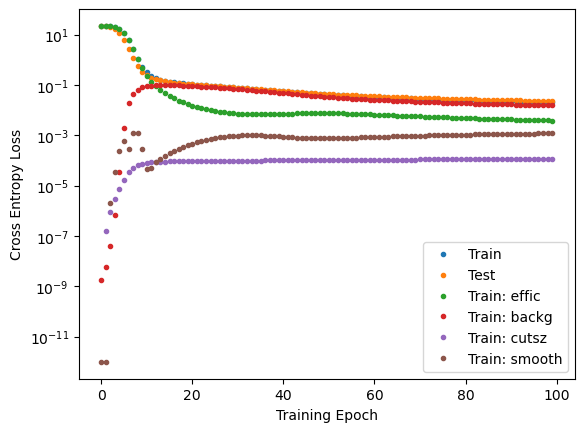

In [12]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

In [21]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor,y_test,net.nets[n],True)

    # check that after reloading the weights we still get the same performance after pretraining
    net.nets[n].eval() # configure the model for evaluation (testing)
    y_pred = net.nets[n](x_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor, m, net.nets[n], targeteffics[n], alpha, beta, gamma, True)
    print("------------")

Target efficiency: 60.0%
Signal     efficiency with net outputs: 62.2%
Background efficiency with net outputs:  0.17561%
Inspecting efficiency loss: alpha=10.0, target=0.600, subnet_effic=0.5956, subnet_backg=0.0098, efficloss=1.943e-04, backgloss=9.766e-04
------------
Target efficiency: 70.0%
Signal     efficiency with net outputs: 72.1%
Background efficiency with net outputs:  0.37632%
Inspecting efficiency loss: alpha=10.0, target=0.700, subnet_effic=0.6984, subnet_backg=0.0174, efficloss=2.546e-05, backgloss=1.745e-03
------------
Target efficiency: 80.0%
Signal     efficiency with net outputs: 81.4%
Background efficiency with net outputs:  1.20421%
Inspecting efficiency loss: alpha=10.0, target=0.800, subnet_effic=0.7955, subnet_backg=0.0369, efficloss=2.001e-04, backgloss=3.689e-03
------------
Target efficiency: 90.0%
Signal     efficiency with net outputs: 89.3%
Background efficiency with net outputs:  5.26844%
Inspecting efficiency loss: alpha=10.0, target=0.900, subnet_effic

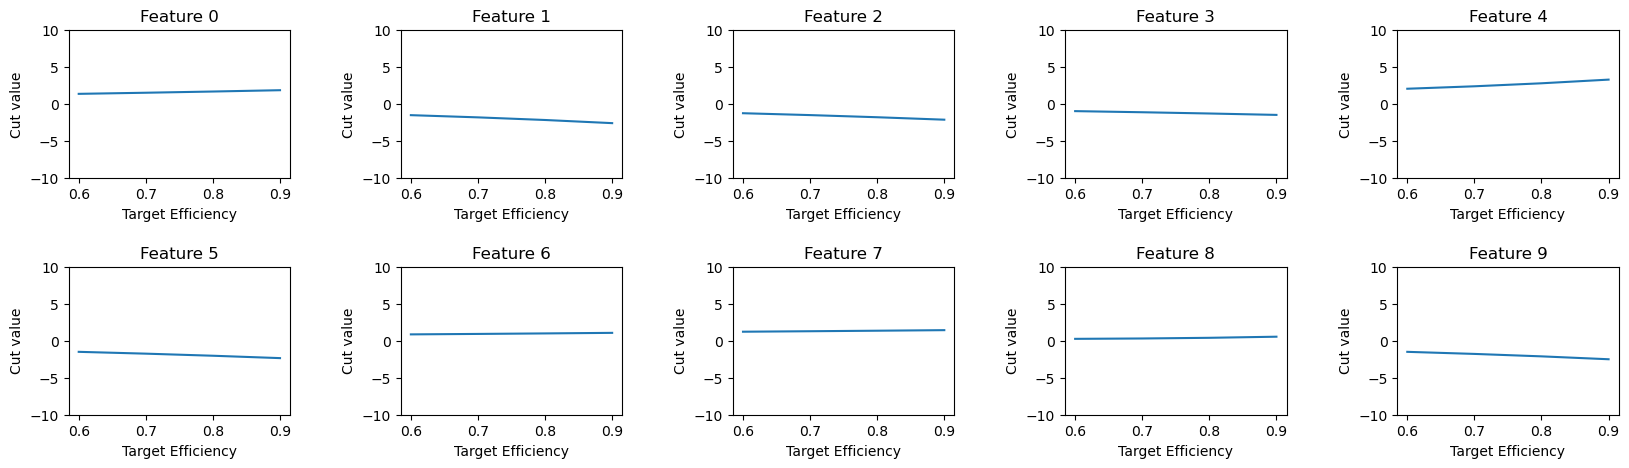

In [14]:
# Distributions of cuts
LearningCutsUtils.LearningCutsUtils.plotcuts(net)

Target efficiency: 60.0%


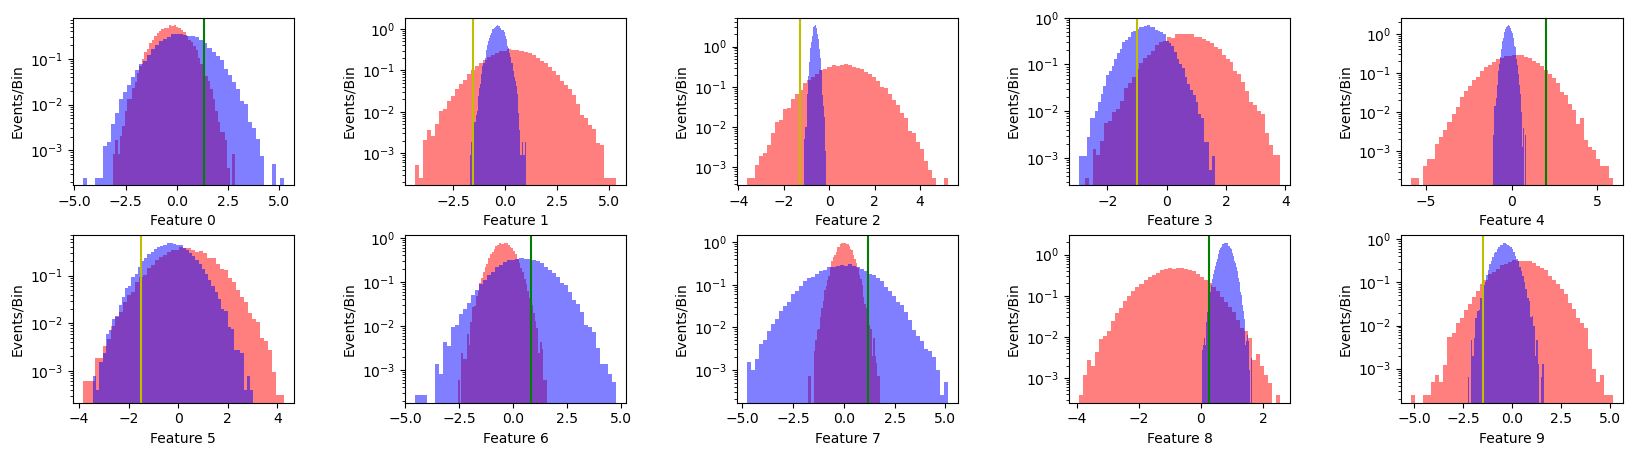

Target efficiency: 70.0%


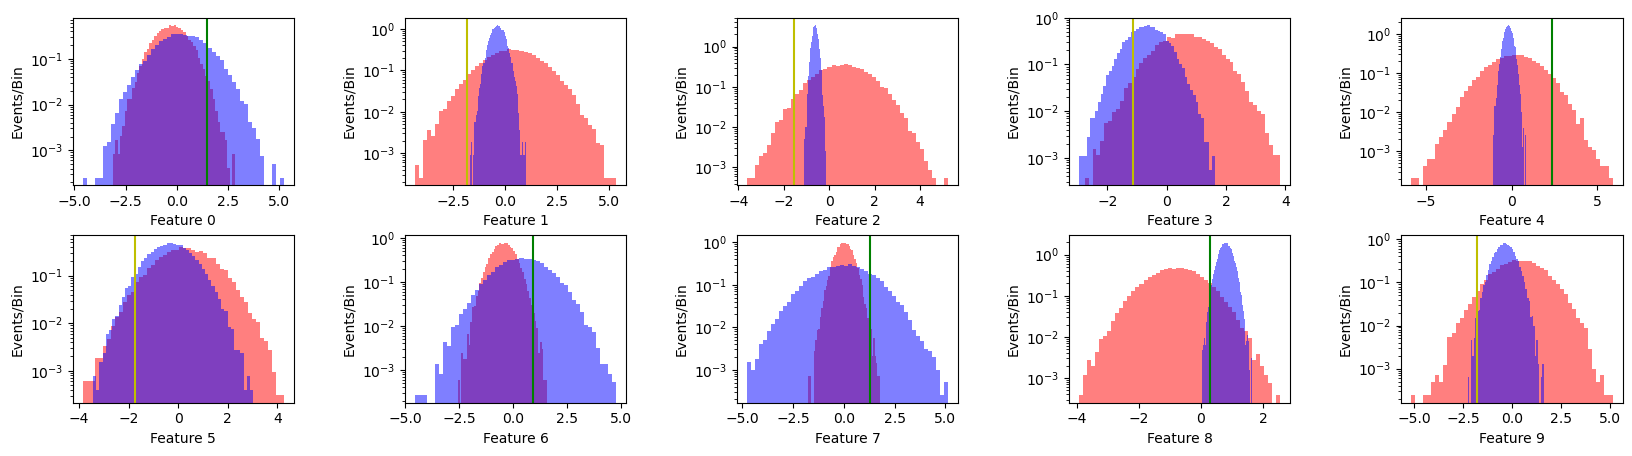

Target efficiency: 80.0%


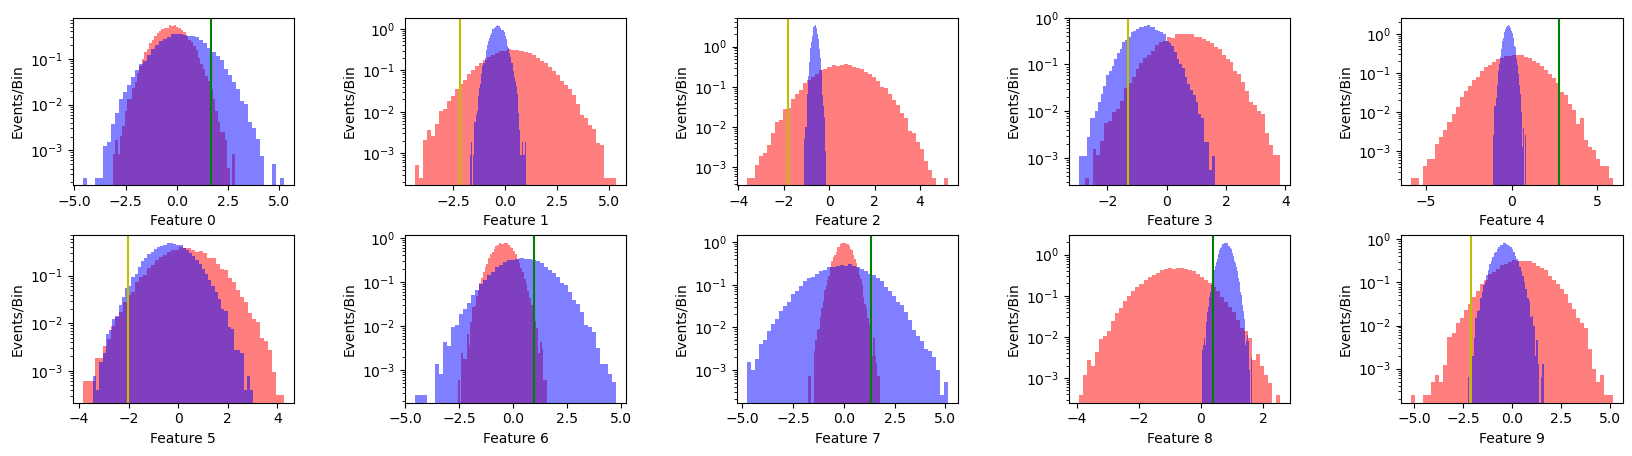

Target efficiency: 90.0%


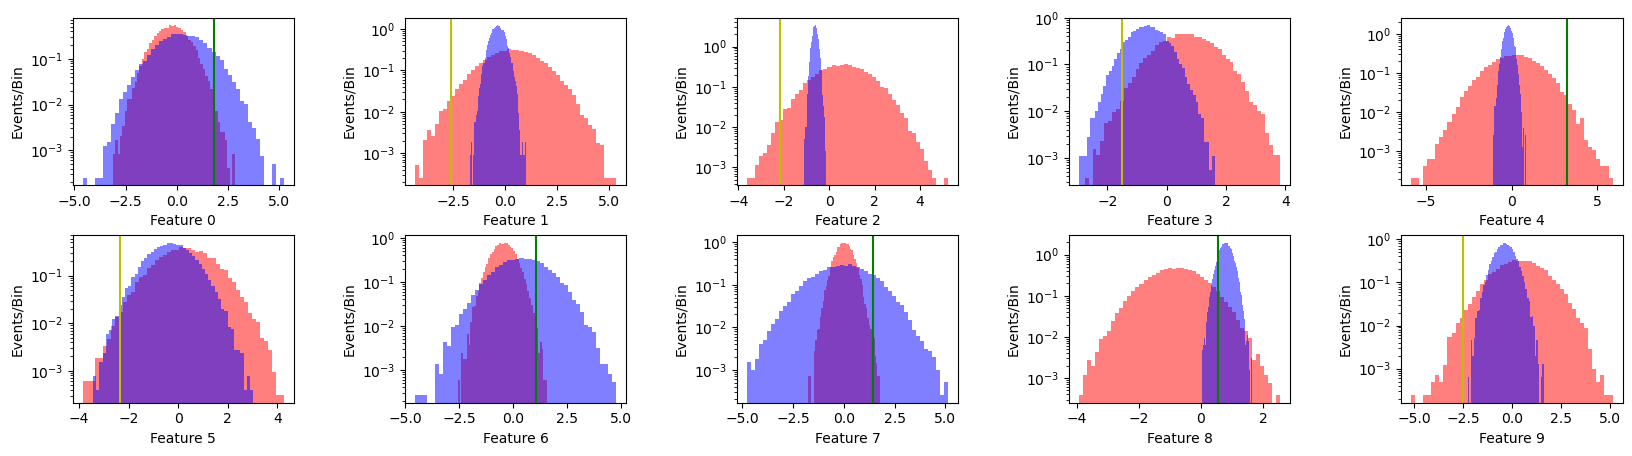

In [15]:
LearningCutsUtils.LearningCutsUtils.plotfeatures(net,x_signal,x_backgr,sc)

To do:
* Hyperparameter scan.
* Using real photon ID variables instead of dummies (Scott)
* documentation for LearningCutsUtils
* make separate files for classes, utility functions
* consider making some utility functions member functions of a network class
* \_\_init\_\_.py setup for LearningCutsUtils
* think more about how to smooth cuts vs pT, the current smoothing procedure is a three-point contraction that seems to be working, but maybe isn't optimal.
* I suspect there's some relationship between the number of input variables, the scale factor we use in the activation function, and how we handle the product of the activated features.  We are basically computing:

$$
\prod_{f=0}^{m} \mathrm{sigmoid}(kx_{f}') = \prod_{f=0}^{m} \frac{1}{1-e^{-kx_{f}'}}
$$

where $f$ is an index over the number of features, and $k$ is the activation scale factor.  One problem is that this will approach $0$ as $m\to\infty$, even for signal where $x_{f}'$ is positive (and hopefully large).  In order to mitigate this, we can take the $k$'th root of the product:

$$
\sqrt[k]{\prod_{f=0}^{m} \mathrm{sigmoid}(kx_{f}')}
$$

Further, I suspect the correct thing to do is to set $k=m$, so we have:

$$
\sqrt[m]{\prod_{f=0}^{m} \mathrm{sigmoid}(mx_{f}')}
$$

and we remove one hyperparameter ($k$) that otherwise needs to be tuned for the number of features ($m$).  To do: test that this works for values of $m$ ranging from 2 to, say, 20.

Another way to look at it is that

$$
\prod_{f=0}^{m} \mathrm{sigmoid}(kx_{f}') \approx (\mathrm{sigmoid}(k\bar{x}'))^{m}
$$

so taking the $m$'th root of the product gets us back to something like $\mathrm{sigmoid}(kx')$, where again we probably want a value of $k$ on the order of $m$.  We've seen that having $k$ in the range of $4-8$ helps the signal efficiency calculated in the loss to be closer to the actual signal efficiency from applying the cuts, but maybe that's just because I've been testing with $m=10$.  This is something that would be nice to study in detail. 